In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *


In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = "yy_quadh"

In [5]:
altfile="yy_quadh_bkg10_soft025_md_allsig_{base}"
# signal = ObjIter([])
signal = ObjIter([ Tree(f, report=False, altfile=altfile) for f in tqdm(module.signal_list) ])
# signal = ObjIter([ Tree(f, report=False) for f in tqdm(module.full_signal_list) ])

# bkg = ObjIter([])
bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List, altfile=altfile), Tree(module.Run2_UL18.TTJets, altfile=altfile)])

data = ObjIter([])
# data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List) ])

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


In [46]:

pt_filter = eightb.selected_jet_pt()
btag_filter = eightb.selected_jet_btagwp()

event_filter = FilterSequence(pt_filter, btag_filter)
signal = signal.apply(event_filter)
bkg = bkg.apply(event_filter)
data = data.apply(event_filter)

100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


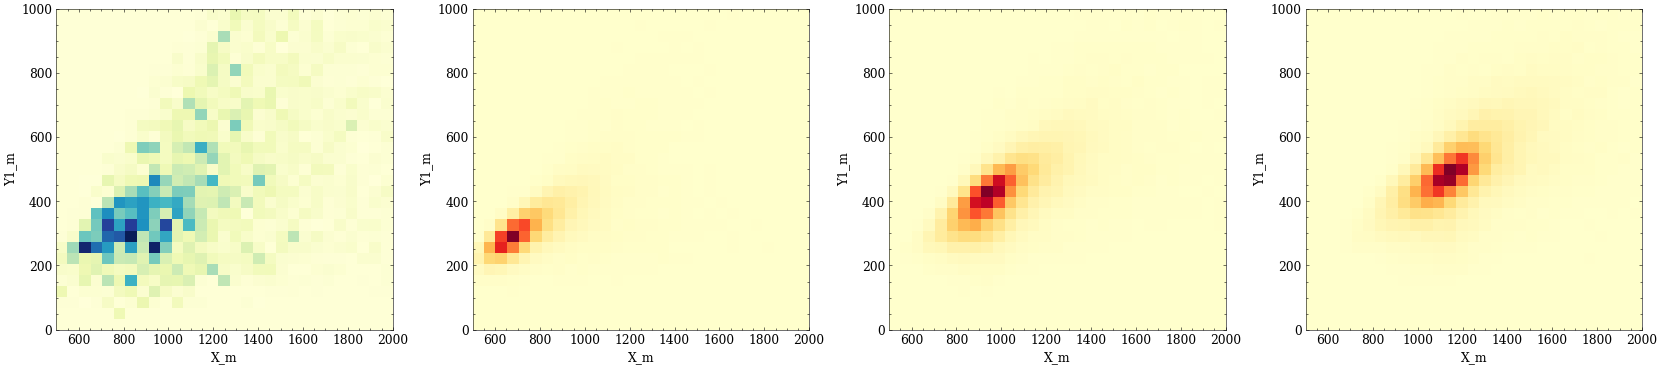

In [47]:
study.quick2d( 
    signal+bkg,
    varlist=['X_m','Y1_m'],
    binlist=[(500,2000,30),(0,1000,30)]
)

In [48]:
def xy_flat(t):
    x, y = t.X_m, t.Y1_m

    return x + y

100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


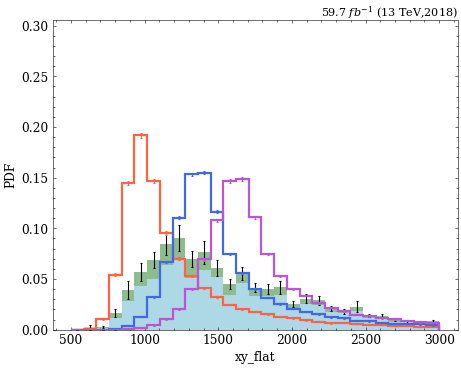

In [49]:
study.quick( 
    signal+bkg,
    varlist=[xy_flat],
    binlist=[(500,3000,30)],
    efficiency=True,
)

In [82]:
xy = np.abs(np.stack(ak.unzip(bkg.apply(lambda t:t[['X_m','Y1_m','Y2_m']]).cat),axis=-1))

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import FeatureAgglomeration

# pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=1))]).fit(np.log10(xy))
pipeline = Pipeline([('scaling', StandardScaler()), ('fa', FeatureAgglomeration(n_clusters=1))]).fit(np.log10(xy))

In [98]:
def xy_pca(t, pca=pipeline):
    # if 'xy_pca' in t.fields: return t.xy_pca

    args = t.X_m, t.Y1_m, t.Y2_m
    xy = np.abs(np.stack(args,axis=1))
    x =  pca.transform(np.log10(xy))
    t.extend(xy_pca=x[:,0])
    return x[:,0]

100%|██████████| 2/2 [00:23<00:00, 11.97s/it]


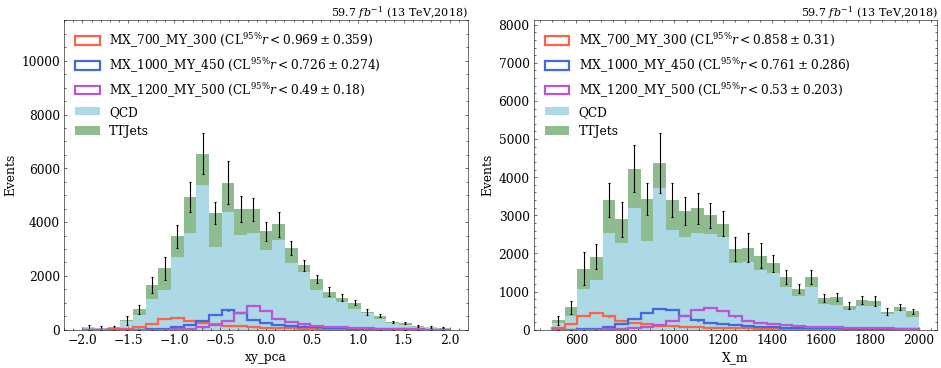

In [99]:
study.quick( 
    signal+bkg,
    varlist=[xy_pca,'X_m'],
    binlist=[(-2,2,30),(500,2000,30)],
    # efficiency=True,
    limits=True,
    legend=True,
)

In [100]:
bkg.xy_pca

[<Array [-1.15, -0.652, -0.873, ... 1.59, 0.574] type='7511 * float64'>, <Array [-0.67, 0.483, -1.44, ... 0.34, -0.922] type='16400 * float64'>]

100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


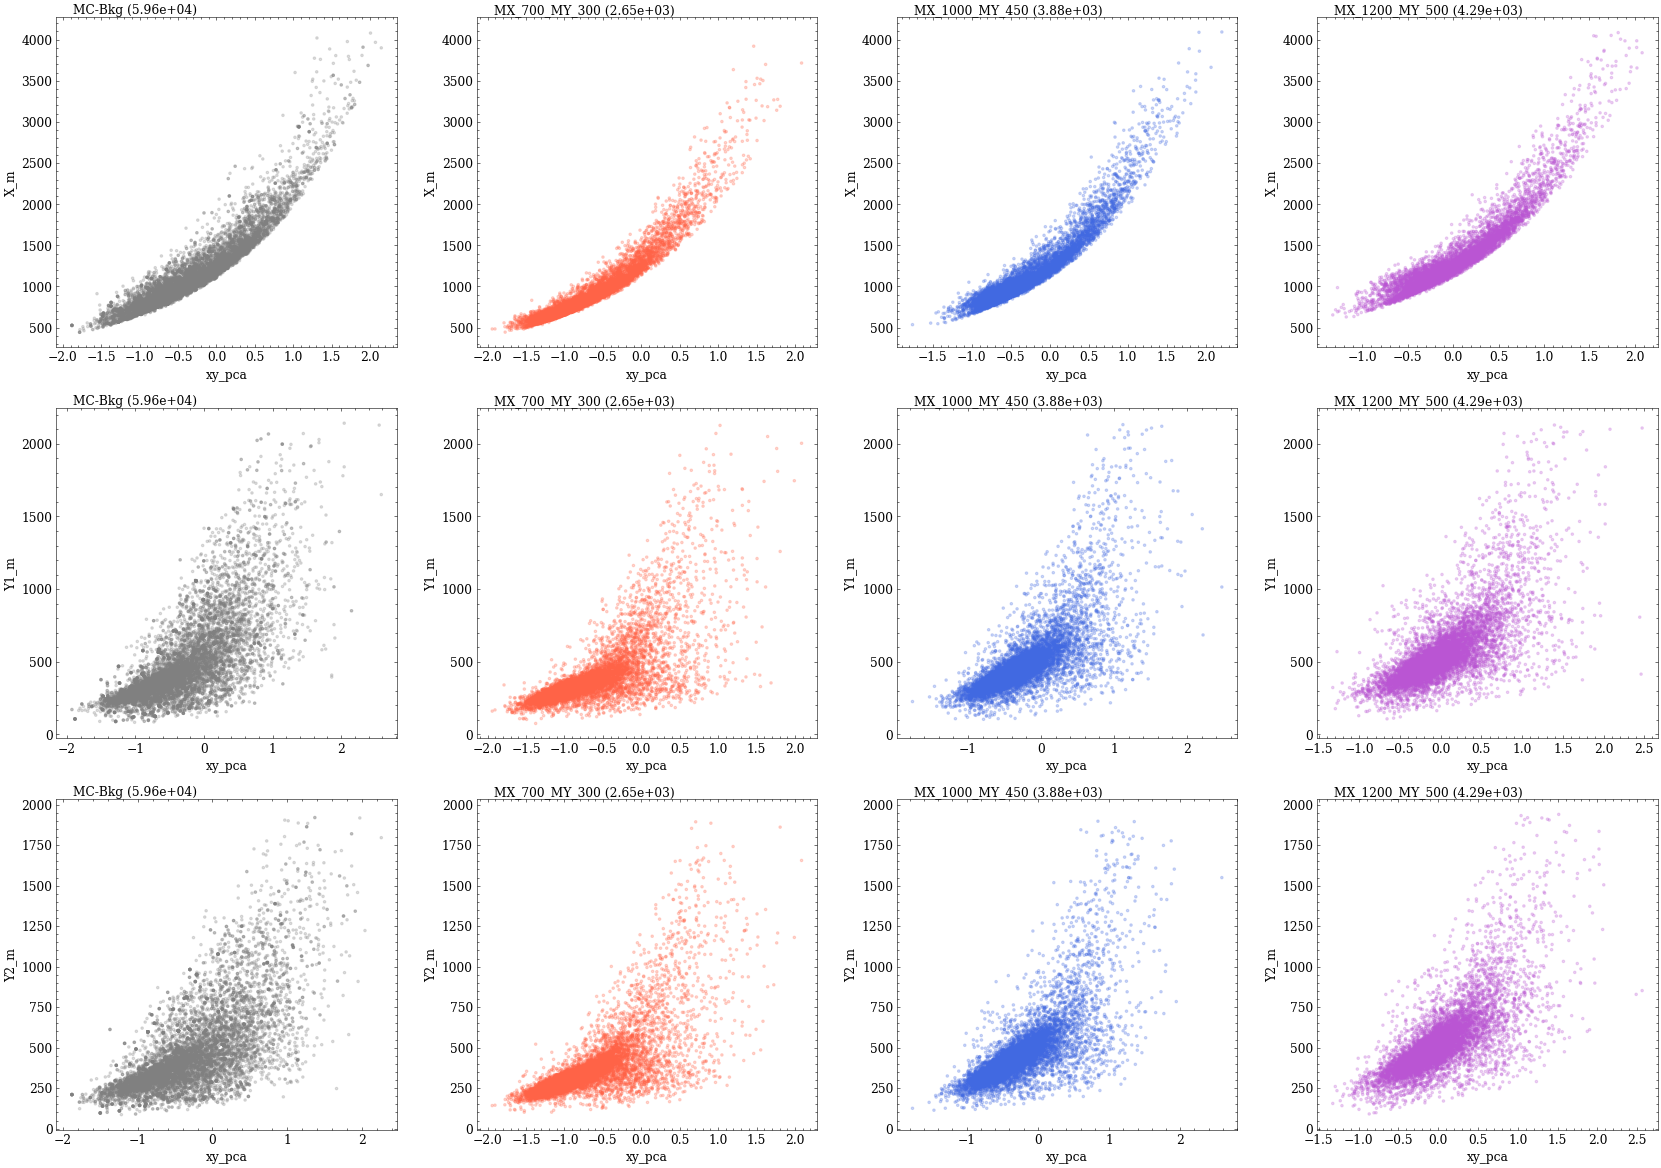

In [104]:
study.quick2d( 
    signal+bkg,
    xvarlist=['xy_pca']*3,
    yvarlist=['X_m','Y1_m','Y2_m'],
    # binlist=[(-2,2,30),(500,2000,30)],
    # efficiency=True,
    scatter=True,
    legend=True,
)

In [108]:
xw = get_bin_widths(np.linspace(500,2000,30)).mean()

100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


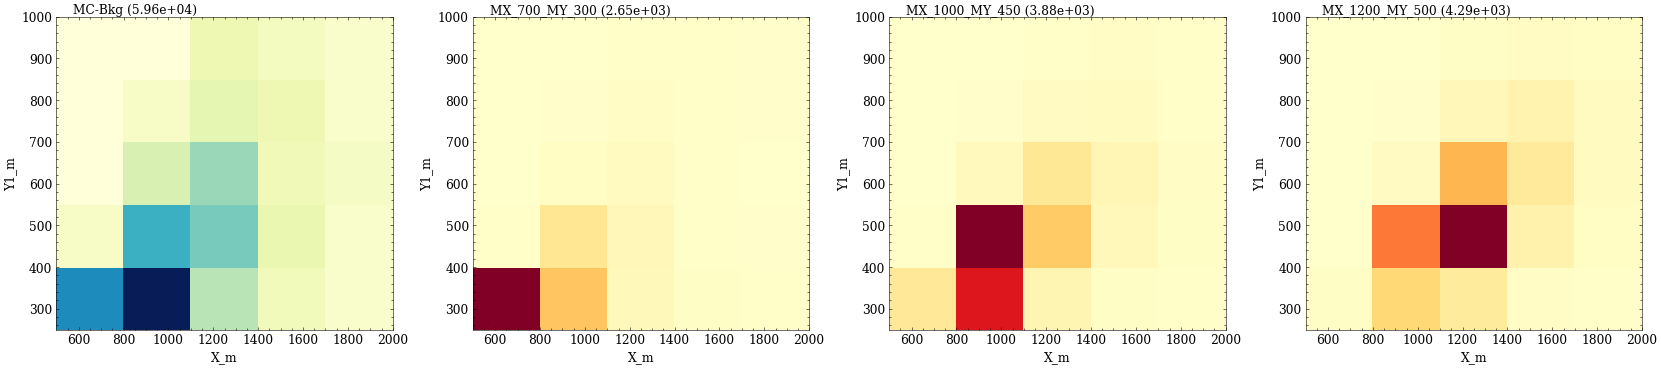

In [134]:
study.quick2d( 
    signal+bkg,
    varlist=['X_m','Y1_m'],
    binlist=[(500,2000,6),(250,1000,6)],
    # efficiency=True,
    # scatter=True,
    legend=True,
)

In [131]:
def xy_unrolled(t):
    x, y = t.X_m, t.Y1_m

    xw = (2000-500)/5
    yw = (1000-250)/5

    z = 4 * (x//xw) + y//yw

    return z

100%|██████████| 2/2 [00:00<00:00,  3.62it/s]


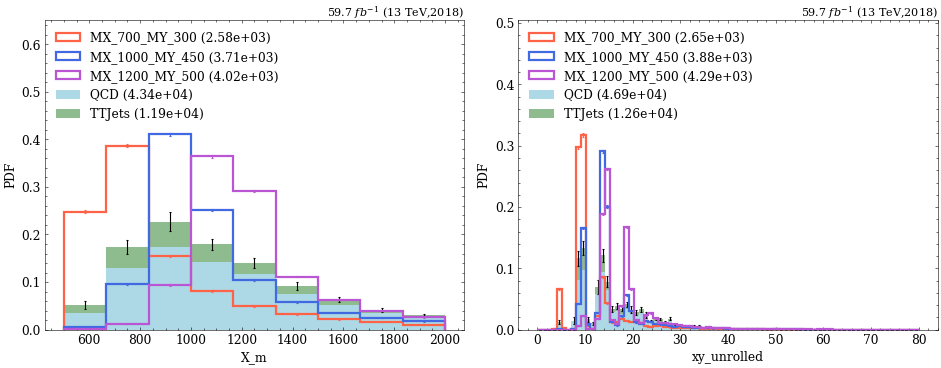

In [135]:
study.quick( 
    signal+bkg,
    varlist=['X_m',xy_unrolled],
    binlist=[(500,2000,10), (0,80,80)],
    efficiency=True,
    # scatter=True,
    legend=True,
)